In [1]:
'''
Author: Ivan Gvozdanovic
Date: 02/28/2025

Sampling Fibers, using Deep Q-learning algorithm.

''';

In [1]:
import scipy
import scipy.io
from datetime import date, time, datetime as Date, time, datetime
from scipy import optimize
import networkx as nx
import ast
import random
import os
import re
import numpy as np
import time as Time
from operator import itemgetter
import math as m
import copy as cpy
import matplotlib.pyplot as plt
import os
import pickle

import torch
import torch.optim as optim

from RedistrictingENV import PolytopeENV as Env

from gerrychain import (Partition, Graph, updaters, constraints, accept, metagraph)
from gerrychain.proposals import recom
from gerrychain.constraints import contiguous
from functools import partial

$\Large \textbf{Q-learning algorithm}$

In [3]:
from MultiDiscrete_Q_learning import DQNMulitDiscrete, \
                                    update_target_network, \
                                    run_episode, \
                                    exploration_control, \
                                    adjust_learning_rate, \
                                    ReplayBuffer, \
                                    RewardBuffer, \
                                    select_optimal_action

$\Large \textbf{Reward functions}$

In [4]:
# from reward_functions import reward_cost, calculate_reward1, calculate_reward2, calculate_reward3

$\Large \textbf{Initial Solution}$

In [5]:
from helper_functions import create_fiber_sampling_erdos_renyi_graph, \
                             extract_distance_matrix, \
                             moving_average, \
                             create_state_graph, \
                             permute_moves,\
                             group_keys_by_value,\
                             create_state_vector, \
                            create_action_vector
    
                             

graph = Graph.from_json(os.getcwd() + '/data/gerrymandria.json')

"Produce an initial solution"
my_updaters = {
    "population": updaters.Tally("TOTPOP", alias='population'),
    "cut_edges": updaters.cut_edges
}

initial_partition = Partition(
    graph,
    assignment="district",
    updaters=my_updaters
)

partition_num = len(initial_partition.parts.keys())
node_num = len(graph.nodes)

partition_num = len(initial_partition.parts.keys())
initial_state = create_state_vector(node_num, partition_num, initial_partition.parts)
print(len(initial_state), initial_state)

objective_table = [] # cost vector
initial_states = {} # dictionary holding the initial states.
reward_lists = [] # list holding the rewrds for each edge in the subproblem. We read it off to compute the travel cost.

patches = 1
nodes_per_patch = 6
p = 0.5
graph_num = 1

#Pick the file to the problem:
file = 'TSP_MultiDiscrete_DQN'


single_flips = metagraph.all_valid_flips(initial_partition, constraints=[contiguous])
single_flips_list = list(single_flips)
single_flips_list = sorted(single_flips_list, key=lambda x: (list(x.values())[0], list(x.keys())[0]))
available_actions = group_keys_by_value(single_flips_list)
print(available_actions)

512 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [6]:
print(initial_partition.subgraphs)
sub = [graph.subgraph(c).copy() for c in initial_partition.subgraphs]

print(sub)

print(initial_partition.graph)

len(initial_partition.parts['1']) 

<SubgraphView with 8 and 0 cached graphs>
[<Graph [8 nodes, 7 edges]>, <Graph [8 nodes, 7 edges]>, <Graph [8 nodes, 7 edges]>, <Graph [8 nodes, 7 edges]>, <Graph [8 nodes, 7 edges]>, <Graph [8 nodes, 7 edges]>, <Graph [8 nodes, 7 edges]>, <Graph [8 nodes, 7 edges]>]


8

$\Large \textbf{Main training loop}$

In [8]:
save_data = True  # save Q table data and cost vector data.
save_plots = False  # save the plots


# Example usage for running episodes
num_episodes = 1
gamma = 0.99
epsilon = 1
d = 1/num_episodes # Decrement for the exploration parameter.
initial_lr = 0.007
decay_rate = 0.95


# Initialize variables for target network updates
step_count = 0
total_step_count = 50000
update_target_freq = 300  # Update the target network every 1000 steps


state_size = len(initial_state)
action_space = [partition_num, 10]  # Example action space sizes


train_freq = 60 # after how many steps do we train the newtork
buffer_size = 2000  # Maximum size of the buffer
batch_size = 128  # Number of experiences to sample in each training step
bad_batch_size = 16
replay_buffer = ReplayBuffer(buffer_size, batch_size)
reward_buffer = RewardBuffer(buffer_size)


# Initialize the networks and optimizer
q_network = DQNMulitDiscrete(state_size=state_size, action_space=action_space, learning_rate=initial_lr)  # Example sizes
target_q_network = DQNMulitDiscrete(state_size=state_size, action_space=action_space, learning_rate=initial_lr)


# Copy initial weights to the target network
update_target_network(q_network, target_q_network)


decay_increment = initial_lr/total_step_count
optimizer = optim.Adam(q_network.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.000001)



episodic_rewards = []
exploration_rates = []
learning_rates = []

In [9]:
# Convert dictionary values to a list of arrays
visited_states = [np.array(initial_state)]
visited_states = np.stack(visited_states)
#  visited_states,  # visited_states

#Initialize the environment.
env = Env(initial_state, # initial_state
         initial_partition,
         50, # show_path_num
         partition_num,  
         node_num, # node_num
         )

c:\Users\gvozd\Desktop\University\Research\Code\Combinatorial RL\Redistricting using RL\DQN\MultiDiscrete_Q_learning.py:186: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states = torch.FloatTensor(states)


Step: 1000 ||| Total reward: 0.0
Step: 2000 ||| Total reward: 0.125
Step: 3000 ||| Total reward: 0.0
Step: 4000 ||| Total reward: -0.5
Step: 5000 ||| Total reward: -0.125
Step: 6000 ||| Total reward: 0.125
Step: 7000 ||| Total reward: -0.5
Step: 8000 ||| Total reward: 0.125
Step: 9000 ||| Total reward: 0.0
Step: 10000 ||| Total reward: -0.375
Step: 11000 ||| Total reward: 0.25
Step: 12000 ||| Total reward: 0.0
Step: 13000 ||| Total reward: 0.25
Step: 14000 ||| Total reward: -0.25
Step: 15000 ||| Total reward: -0.375
Step: 16000 ||| Total reward: 0.375
Step: 17000 ||| Total reward: 0.5
Step: 18000 ||| Total reward: 0.5
Step: 19000 ||| Total reward: -0.5
Step: 20000 ||| Total reward: -0.375
Step: 21000 ||| Total reward: 0.5
Step: 22000 ||| Total reward: -0.25
Step: 23000 ||| Total reward: 0.125
Step: 24000 ||| Total reward: 0.25
Step: 25000 ||| Total reward: 0.0
Step: 26000 ||| Total reward: 0.125
Step: 27000 ||| Total reward: 0.125
Step: 28000 ||| Total reward: 0.75
Step: 29000 ||| Tota

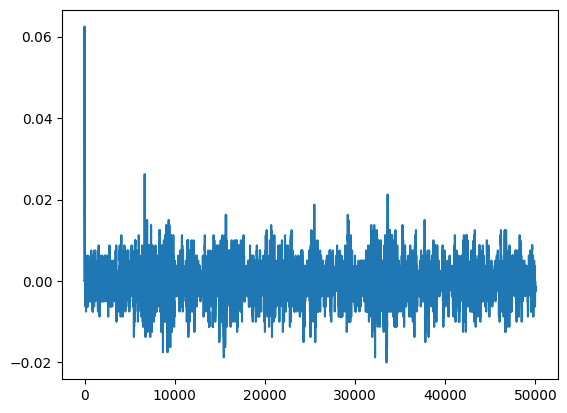

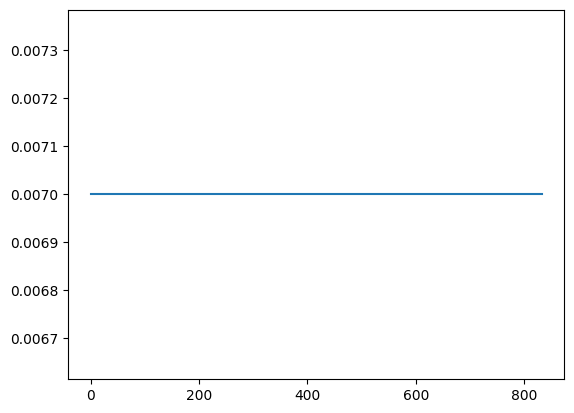

It took 3.9050052404403686 minutes to run 1 episodes.


In [10]:
start_time = Time.time()


for episode in range(num_episodes):

    # Adjust learning rate before each episode
    #adjust_learning_rate(optimizer, initial_lr, episode, learning_rates, decay_increment)

    # Adjust exporation rate before each episode.
    epsilon, epsilon_f = exploration_control(epsilon, episode, num_episodes, d, 2) 
    exploration_rates.append(epsilon_f)


    total_reward, step_count, best_partition = run_episode(env, 
                                                            q_network, 
                                                            target_q_network, 
                                                            optimizer, 
                                                            scheduler,
                                                            replay_buffer,
                                                            reward_buffer,
                                                            epsilon_f, 
                                                            gamma, 
                                                            action_space, 
                                                            partition_num,
                                                            node_num,
                                                            update_target_freq, 
                                                            train_freq,
                                                            step_count,
                                                            total_step_count,
                                                            learning_rates)
    
    #print(f"Episode {episode}: Total Reward = {total_reward}")
    print(f"Best partition: {best_partition[0].parts} with reward: {best_partition[1]}")
    episodic_rewards.append(total_reward)
    moving_avg_reward = moving_average(total_reward, 100)
    x_axis = [i for i in range(len(moving_avg_reward))]
    plt.plot(x_axis, moving_avg_reward)
    plt.show()
    x_axis = [i for i in range(len(learning_rates))]
    plt.plot(x_axis, learning_rates)
    plt.show()


#Save the Q table.
if save_data:
    time = Time.localtime()
    current_time = Time.strftime("%H-%M-%S", time)
    date = datetime.now()
    date_trunc = date.isoformat()[0:10]
    torch.save(q_network.state_dict(), 'Models/q_network_weights.pth')

# x_axis = [i for i in range(len(episodic_rewards))]
# plt.plot(x_axis, episodic_rewards)
# plt.show()
# x_axis = [i for i in range(len(exploration_rates))]
# plt.plot(x_axis, exploration_rates)
# plt.show()
# x_axis = [i for i in range(len(learning_rates))]
# plt.plot(x_axis, learning_rates)
# plt.show()
    

end_time = Time.time()

print(f'It took {(end_time-start_time)/60} minutes to run {num_episodes} episodes.')


    
    
    
   



$\Large \textbf{Examine the optimal policy on a Unseen Sampling Problem}$

In [11]:



initial_states = {}
available_actions, initial_states = create_fiber_sampling_erdos_renyi_graph(file, initial_states, nodes_per_patch, 0.9, 100)

q_network = DQNMulitDiscrete(state_size=state_size, action_space=action_space, learning_rate=initial_lr)  # Example sizes
q_network.load_state_dict(torch.load('Models/q_network_weights.pth'))
q_network.eval()

for s in range(1):
    
    # Convert dictionary values to a list of arrays
    visited_states = [np.array(initial_states[s])]
    visited_states = np.stack(visited_states)


    #Initialize the environment.
    env = Env(initial_states, # initial_state
             num_episodes, # total_episodes
             50, # show_path_num
             visited_states,  # visited_states
             available_actions, # basis_moves
             nodes_per_patch, # node_num
             0, # P
             lb, #lb
             )

    total_reward = 0
    state = env.reset()
    steps = 100
    for step in range(steps):

        action = select_optimal_action(q_network, state)

        action_rounded = np.array(np.round(action), dtype=int)
        action_rounded += lb
        all_actions = [np.multiply(action_rounded[i], available_actions[i]) for i in range(len(action_rounded))]
        all_actions = np.stack(all_actions)
        action_full = np.sum(all_actions, 0)

        print("State: \n", state)
        print("Action:\n", action_full)

        # Perform action in the environment
        next_state, reward, done, _ = env.step(action)


        state = next_state
        total_reward += reward
    print(f'Total reward for {steps} is: {total_reward}')

Initial solution: 
 15 [1 1 1 1 1 1 1 1 1 1 0 1 0 1 1]
Sufficient statistic: 
 [5. 5. 4. 4. 3. 5.]
Initial solution: 
 15 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Sufficient statistic: 
 [5. 5. 5. 5. 5. 5.]
Initial solution: 
 15 [1 1 1 1 0 0 1 1 1 1 1 1 1 1 1]
Sufficient statistic: 
 [4. 4. 4. 5. 5. 4.]
Initial solution: 
 15 [1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]
Sufficient statistic: 
 [5. 4. 4. 5. 5. 5.]
Initial solution: 
 15 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Sufficient statistic: 
 [5. 5. 5. 5. 5. 5.]
Initial solution: 
 15 [1 1 1 1 1 1 1 0 1 0 1 1 1 1 1]
Sufficient statistic: 
 [5. 4. 4. 4. 4. 5.]
Initial solution: 
 15 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Sufficient statistic: 
 [4. 4. 5. 5. 5. 5.]
Initial solution: 
 15 [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
Sufficient statistic: 
 [4. 5. 4. 5. 5. 5.]
Initial solution: 
 15 [1 1 1 0 1 1 1 1 0 1 1 1 1 0 0]
Sufficient statistic: 
 [4. 4. 5. 4. 3. 2.]
Initial solution: 
 15 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
Sufficient statistic: 
 [5. 4. 5. 5. 4. 5.]
Initial so

C:\Users\gvozd\AppData\Local\Temp\ipykernel_7008\2021425962.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q_network.load_state_dict(torch.load('Models/q_network_weight

NameError: name 'lb' is not defined